<h2>Twitter Structured Spark Streaming</h2>

<h3>Required Software</h3>

In [1]:
### We use tweepy library to connect to Twitter and conduct analytics on it
import subprocess
import sys

#This function is used to install library on your codebase. Update pip to pip3 if this is what you use.
def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])


install("tweepy")
install("seaborn")

<h3>Spark Streaming</h3>

In [2]:
#Important Imports
import pandas as pd 
#import findspark
#findspark.init()
#findspark.find()
import pyspark
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql import SparkSession
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.sql import Window
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.types import DateType
from pyspark.sql.functions import *
#Notice this new line here
from pyspark.streaming import StreamingContext



appName = "Twitter Real-time Analytics via Spark"
master = "local"
conf = pyspark.SparkConf().set('spark.driver.host','127.0.0.1').setAppName(appName).setMaster(master).set("spark.driver.extraClassPath","C:/Program Files/DbVisualizer/jdbc/postgresql/postgresql.jar")
sc = SparkContext.getOrCreate(conf=conf)
spark = SparkSession.builder \
    .appName("Our Twitter Python Spark SQL example") \
        .getOrCreate()

sc

<SparkContext master=local appName=Twitter Real-time Analytics via Spark>

Now, let's use the Stream using readStream() and extract the string.

In [3]:
# read the tweet data from socket
tweet_df = spark \
    .readStream \
    .format("socket") \
    .option("host", "127.0.0.1") \
    .option("port", 4431) \
    .load()
 #align with the listener port
# type cast the column value
tweet_df_string = tweet_df.selectExpr("CAST(value AS STRING)")

<h3>Tweet Preproecssing - Can you guess what this snippet does?</h3>

In [4]:
#explode() returns a new row for each element in the given array or map.
#alias() returns this column aliased with a new name or names
words = tweet_df_string.withColumn('word', explode(split(col('value'), ' '))) \
    .groupBy('word') \
    .count() \
    .sort('count', ascending=False). \
    filter(col('word').contains('#'))

<h3>Write the words to Memory</h3>

In [5]:
writeTweet = words.writeStream. \
    outputMode("complete"). \
    format("memory"). \
    queryName("second_tweets"). \
    trigger(processingTime='2 seconds'). \
    start()


In [6]:
output_df = spark.sql("select * from second_tweets limit 100")
output_df.show()

+----------------+-----+
|            word|count|
+----------------+-----+
|            #NFL|  663|
|         #Browns|  456|
|       #Steelers|  245|
|  #DeshaunWatson|  175|
|            #nfl|  159|
|     #NFLt_endRT|  122|
|        #Falcons|  106|
|        #Raiders|   97|
|          #NFLRT|   84|
|        #Texans,|   78|
|        #Saints.|   78|
|      #Panthers,|   78|
|        #Broncos|   64|
|     #NFLTwitter|   61|
|       #Chargers|   58|
|         #browns|   54|
|         #Texans|   44|
|        #Bengals|   37|
|#ClevelandBrowns|   35|
|          #49ers|   34|
+----------------+-----+
only showing top 20 rows



<h3>Visualize the most active 10 trends</h3>

In order to visualize the data, it's better to limit the data to specific number of trends for simpler visualizations. We will use <b>seaborn</b> library for visualizations. For more information about seaborn library, check its documentation here https://seaborn.pydata.org/ 
<br/>

Make sure you install the library using <b>pip install seaborn</b>

In [7]:
import subprocess
import sys

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

install("seaborn")

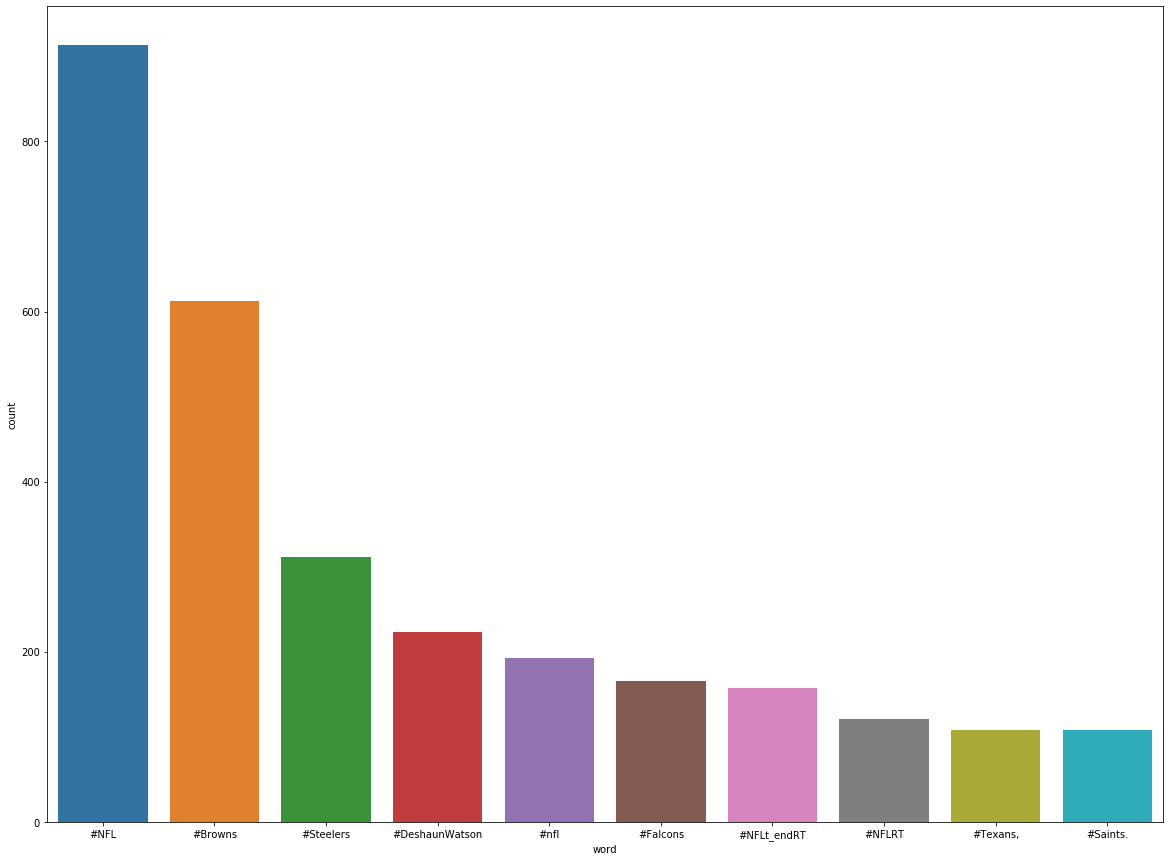

In [9]:
import matplotlib.pyplot as plt

import seaborn as sns
from IPython import display

top_10_dataframes = output_df.sort('count', ascending=False).limit(10).toPandas()
display.clear_output(wait=True)
plt.figure( figsize = ( 20, 15 ) )
sns.barplot( x="word", y="count", data=top_10_dataframes)
plt.show()

In [17]:
writeTweet.stop()

22/02/21 14:38:11 ERROR WriteToDataSourceV2Exec: Data source write support org.apache.spark.sql.execution.streaming.sources.MicroBatchWrite@580ef119 is aborting.
22/02/21 14:38:11 ERROR WriteToDataSourceV2Exec: Data source write support org.apache.spark.sql.execution.streaming.sources.MicroBatchWrite@580ef119 aborted.
22/02/21 14:38:11 WARN TaskSetManager: Lost task 79.0 in stage 240.0 (TID 18652) (192.168.226.128 executor driver): TaskKilled (Stage cancelled)
22/02/21 14:38:11 WARN TaskSetManager: Lost task 80.0 in stage 240.0 (TID 18653) (192.168.226.128 executor driver): TaskKilled (Stage cancelled)
